In [1]:
from google.colab import drive
drive.mount('/content/drive')

!pip install -q pandas pillow

import os
import torch
import pandas as pd
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


import torchvision.transforms as transforms
import struct
import numpy as np
import matplotlib.pyplot as plt





Mounted at /content/drive


In [15]:
def load_mnist_images(filename):
    with open(filename, 'rb') as f:
        _, num, rows, cols = struct.unpack(">IIII", f.read(16))
        images = np.fromfile(f, dtype=np.uint8).reshape(num, 1, rows, cols)  # Reshape to (N, 1, 28, 28)
    return torch.tensor(images, dtype=torch.float32) / 255.0  # Normalize to [0,1]

def load_mnist_labels(filename):
    with open(filename, 'rb') as f:
        _, num = struct.unpack(">II", f.read(8))
        labels = np.fromfile(f, dtype=np.uint8)
    return torch.tensor(labels, dtype=torch.long)


train_images_path = "/content/drive/MyDrive/Colab Notebooks/train-images.idx3-ubyte"
train_labels_path = "/content/drive/MyDrive/Colab Notebooks/train-labels.idx1-ubyte"
train_images = load_mnist_images(train_images_path)
train_labels = load_mnist_labels(train_labels_path)


resize_transform = transforms.Resize((32, 32), antialias=True)
train_images = resize_transform(train_images)

print("Images Tensor Shape:", train_images.shape)
print("Labels Tensor Shape:", train_labels.shape)
print(train_images[0])
print(train_images[0].shape)
print(train_labels[0])

Images Tensor Shape: torch.Size([60000, 1, 32, 32])
Labels Tensor Shape: torch.Size([60000])
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
torch.Size([1, 32, 32])
tensor(5)


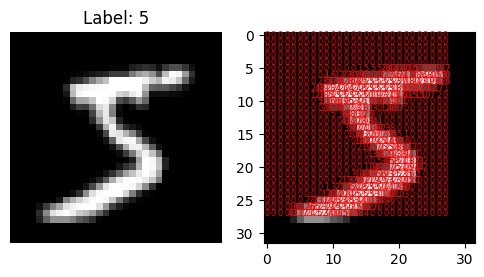

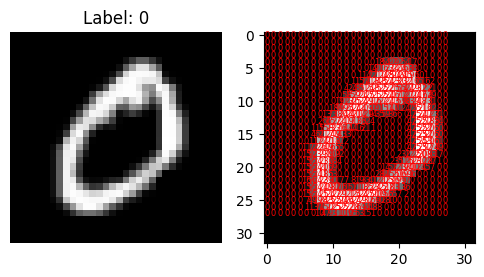

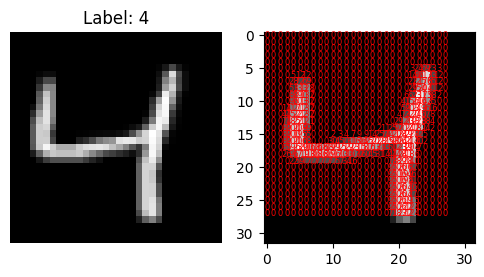

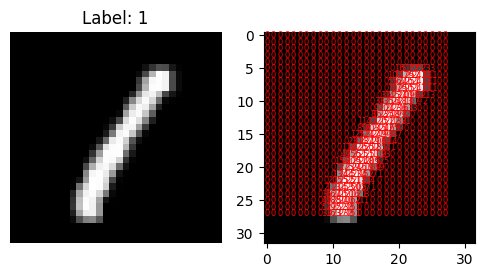

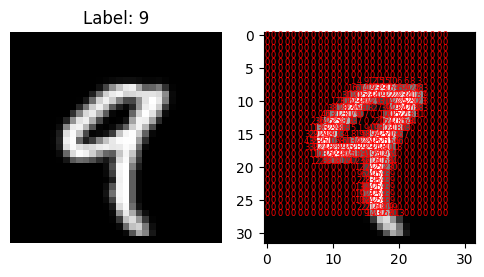

In [16]:
def show_image_with_pixels(image_tensor, label):
    image = image_tensor.squeeze(0).numpy()

    plt.figure(figsize=(6, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap="gray")
    plt.title(f"Label: {label.item()}")
    plt.axis("off")


    plt.subplot(1, 2, 2)
    plt.imshow(image, cmap="gray")
    for i in range(28):
        for j in range(28):
            plt.text(j, i, str(int(image[i, j] * 255)), ha='center', va='center',
                     fontsize=6, color="red")

    plt.show()


for i in range(5):
    show_image_with_pixels(train_images[i], train_labels[i])


In [17]:
import random
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split


X = train_images.view(train_images.shape[0], -1)
print(X[0].shape)
y = train_labels
print(y)


dataset = TensorDataset(X, y)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
generator = torch.Generator().manual_seed(seed)
train_dataset, val_dataset = random_split(dataset, [train_size, val_size], generator=generator)
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


print(f"Training Set: {len(train_dataset)} samples")
print(f"Validation Set: {len(val_dataset)} samples")





torch.Size([1024])
tensor([5, 0, 4,  ..., 5, 6, 8])
Training Set: 48000 samples
Validation Set: 12000 samples


In [19]:

class LeNet5(nn.Module):
  def __init__(self,num_classes):
    super(LeNet5, self).__init__()
    self.model=nn.Sequential(
        nn.Conv2d(1,6,5),
        nn.Tanh(),
        nn.AvgPool2d(2,2),
        nn.Conv2d(6,16,5),
        nn.Tanh(),
        nn.AvgPool2d(2,2),
    )
    self.fc=nn.Sequential(
        nn.Flatten(),
        nn.Linear(16*5*5,120),
        nn.Tanh(),
        nn.Linear(120,84),
        nn.Tanh(),
        nn.Linear(84,num_classes)
    )
  def forward(self,x):
    x=self.model(x)
    x=self.fc(x)
    return x

In [20]:
#0-9
num_classes = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
model = LeNet5(num_classes).to(device)
print(model)

Using device: cuda
LeNet5(
  (model): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=400, out_features=120, bias=True)
    (2): Tanh()
    (3): Linear(in_features=120, out_features=84, bias=True)
    (4): Tanh()
    (5): Linear(in_features=84, out_features=10, bias=True)
  )
)


In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [22]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for batch_idx, (data, targets) in enumerate(train_loader):
            # Reshape for CNN
            data = data.view(-1, 1, 32, 32).to(device)
            targets = targets.to(device)
            #forward
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, targets)
            # Backward
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += targets.size(0)
            correct_train += (predicted == targets).sum().item()

        # Validation
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for data, targets in val_loader:
                data = data.view(-1, 1, 32, 32).to(device)
                targets = targets.to(device)

                outputs = model(data)
                loss = criterion(outputs, targets)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += targets.size(0)
                correct_val += (predicted == targets).sum().item()

        # averages
        avg_train_loss = running_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        train_acc = 100 * correct_train / total_train
        val_acc = 100 * correct_val / total_val

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Train Loss: {avg_train_loss}, Train Acc: {train_acc}%')
        print(f'Val Loss: {avg_val_loss}, Val Acc: {val_acc}%')


    return train_losses, val_losses, train_accuracies, val_accuracies


In [23]:
num_epochs = 20
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs
)

Epoch [1/20]
Train Loss: 0.2579108403294037, Train Acc: 92.28333333333333%
Val Loss: 0.11471754092598954, Val Acc: 96.39166666666667%
Epoch [2/20]
Train Loss: 0.08844483534898609, Train Acc: 97.2625%
Val Loss: 0.08457872305127481, Val Acc: 97.475%
Epoch [3/20]
Train Loss: 0.06070350977879328, Train Acc: 98.15%
Val Loss: 0.06944620580722888, Val Acc: 97.96666666666667%
Epoch [4/20]
Train Loss: 0.0473665549850557, Train Acc: 98.52291666666666%
Val Loss: 0.06490501873986795, Val Acc: 97.96666666666667%
Epoch [5/20]
Train Loss: 0.03945811443364558, Train Acc: 98.75833333333334%
Val Loss: 0.06684471429341163, Val Acc: 98.025%
Epoch [6/20]
Train Loss: 0.031155821715966644, Train Acc: 99.05208333333333%
Val Loss: 0.06675113718460003, Val Acc: 98.10833333333333%
Epoch [7/20]
Train Loss: 0.028435170456951406, Train Acc: 99.15208333333334%
Val Loss: 0.06877730769004363, Val Acc: 98.025%
Epoch [8/20]
Train Loss: 0.023441769818096266, Train Acc: 99.21041666666666%
Val Loss: 0.060194355413666925, V

In [24]:
import matplotlib.pyplot as plt

def plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies):
    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color='tab:red')
    ax1.plot(train_losses, label='Training Loss', color='red', linestyle='-')
    ax1.plot(val_losses, label='Validation Loss', color='red', linestyle='--')
    ax1.tick_params(axis='y', labelcolor='tab:red')
    ax2 = ax1.twinx()
    ax2.set_ylabel('Accuracy (%)', color='tab:blue')
    ax2.plot(train_accuracies, label='Training Accuracy', color='blue', linestyle='-')
    ax2.plot(val_accuracies, label='Validation Accuracy', color='blue', linestyle='--')
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper center')

    plt.title('Training History: Loss and Accuracy')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [25]:

def evaluate_model(model, data_loader, criterion, device):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    predictions = []
    true_labels = []

    with torch.no_grad():
        for data, targets in data_loader:
            data = data.view(-1, 1, 32, 32).to(device)
            targets = targets.to(device)

            outputs = model(data)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(targets.cpu().numpy())

    accuracy = 100 * correct / total
    avg_loss = test_loss / len(data_loader)

    return avg_loss, accuracy, predictions, true_labels



In [26]:

val_loss, val_accuracy, val_predictions, val_true_labels = evaluate_model(
    model, val_loader, criterion, device
)
print(f'Final Validation Loss: {val_loss}')
print(f'Final Validation Accuracy: {val_accuracy}%')

Final Validation Loss: 0.07665872864265597
Final Validation Accuracy: 98.25%


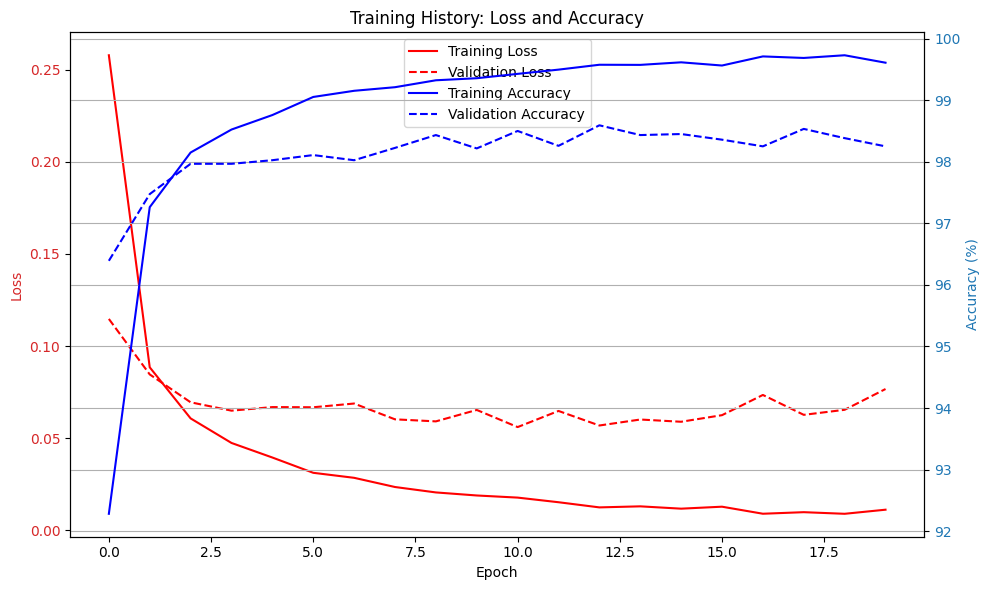

In [27]:
plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies)